### Technical Report 
*Problem Statement, Data, EDA, Image preprocessing*

[Problem & Goals](#a) | [Data](#2) | [EDA](#3) | [Image preprocessing](#4) | [Model](aws_pizza_classifier_keras.ipynb) | [Results](model.ipynb) | [Summary](model.ipynb)

In [187]:
# standard imports
import os, glob, fnmatch
import pandas as pd
import numpy as np

# image processing imports
import cv2

# plotting imports
import seaborn as sns
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib import cm as cm
%matplotlib inline

---

## <a name="a">Problem & Goals</a>

Ever wonder if there is pizza in your immediate surroundings? Of course — that's a totally normal human emotion. And that's where the Pizza Detector™ comes to the rescue. 

The goal of this project is to first develop & train a model that recognizes a specific food category (in this case pizza, because why not pizza?) from a single image of that particular food. A longer term goal would be to expand the model to be a multi-label classifier that recognizes many other food categories and then ultimately predicts calories and other nutritional info from a photo.

On a more serious note, tracking food intake for weight loss or to manage medical conditions (ie diabets, food allergies, etc) can be fairly labor intensive (and frankly annoying) as it usually requires manually entering nutritional info into a fitness/food tracking app. Because of this, most people don't stick with tracking their food intake for very long and this can potentially lead to weight gain and other health problems.



---

## <a name="2">Data</a>

The data set is comprised of 2,000 food photos that are labeled "not pizza" plus 2,000 photos labeled "pizza" that come from randomly sampling [The Food-101 Data Set](https://www.vision.ee.ethz.ch/datasets_extra/food-101/) (and supplementing with an additional 1,000 photos of pizza from [ImageNet](http://image-net.org/synset?wnid=n07873807)). The The Food-101 Data Set dataset includes a 101 food categories, with 1,000 images per category taken from [Foodspotting.com](http://www.foodspotting.com/). The data set still contains some noise — mostly in the form of intense colors and sometimes wrong labels. 

In [2]:
path = '/Users/VanessaG/Desktop/DSI-SF-2-vnessified/capstone/data_sources/food-101/images'
food_categories = {}
folders = os.listdir(path)
for folder in folders[2:]:
    food_categories[folder] = len(os.listdir(os.path.join(path,folder)))
print food_categories

{'churros': 1000, 'hot_and_sour_soup': 1000, 'samosa': 1000, 'sashimi': 1000, 'pork_chop': 1000, 'spring_rolls': 1000, 'panna_cotta': 1000, 'beef_tartare': 1000, 'greek_salad': 1000, 'foie_gras': 1000, 'tacos': 1000, 'pad_thai': 1000, 'poutine': 1000, 'ramen': 1000, 'pulled_pork_sandwich': 1000, 'bibimbap': 1000, 'beignets': 1000, 'apple_pie': 1000, 'crab_cakes': 1000, 'risotto': 1000, 'paella': 1000, 'steak': 1000, 'baby_back_ribs': 1000, 'miso_soup': 1000, 'frozen_yogurt': 1000, 'club_sandwich': 1000, 'carrot_cake': 1000, 'falafel': 1000, 'bread_pudding': 1000, 'chicken_wings': 1000, 'gnocchi': 1000, 'caprese_salad': 1000, 'creme_brulee': 1000, 'escargots': 1000, 'chocolate_cake': 1000, 'tiramisu': 1000, 'spaghetti_bolognese': 1000, 'mussels': 1000, 'scallops': 1000, 'baklava': 1001, 'edamame': 1000, 'macaroni_and_cheese': 1000, 'pancakes': 1000, 'garlic_bread': 1000, 'beet_salad': 1000, 'onion_rings': 1000, 'red_velvet_cake': 1000, 'grilled_salmon': 1000, 'chicken_curry': 1000, 'dev

---

## <a name="3">Data cleaning & munging</a>
Because the data is all image based in the form of pixels, the concept of "cleaning" isn't really applicable. It does make sense to employ standardizaiton techniques to adjust for differences in lighting and other artifacts caused by different camera types, etc used in the photography of the food items. I used the Keras `ImageDataGenerator` class  to do this in the [Image preprocessing](#4) section following EDA.   

However, I do some light data manipulation and munging using OpenCV methods to explore the relationshop between RGB & HSV values on pizza vs non pizza images. First I read in each image with `cv2.imread()`, normalize with `cv2.normalize()` — this divides each pixel's value by the sum of the pixels value over all channels which removes distortions caused by lights and shadows in an image. Then using `cv2.mean()` I calculate the mean  RGB and HSV values for each image returning tuples from `cv2.cvtColor()` using `cv2.COLOR_BGR2RGB` and `cv2.COLOR_BGR2HSV` respectively. I created a dataframe from the color values and add height, width and total pixels just for good measure (since images are represented by numpy arrays, using `.shape` gives pixel height, width and 3 color channels).

In [158]:
df.to_csv('image_info.csv')

In [185]:
df = pd.read_csv('image_info.csv', index_col=0)
df.head()

,label,red,green,blue,hue,sat,val,img_height,img_width,total_px,short_path,full_path
0,0,0.232010,0.121889,0.040963,36.224313,0.808038,0.232448,512,384,196608,train/not_pizza/10060.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
1,0,0.637750,0.452795,0.490195,205.991908,0.468141,0.679158,512,512,262144,train/not_pizza/1008028.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
2,0,0.398433,0.340697,0.371352,175.903364,0.374069,0.461239,512,512,262144,train/not_pizza/1008185.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
3,0,0.584648,0.307440,0.103829,64.419616,0.809770,0.584693,512,512,262144,train/not_pizza/1012128.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...
4,0,0.512543,0.472196,0.413072,104.964425,0.303246,0.529292,512,512,262144,train/not_pizza/1013559.jpg,/Users/VanessaG/Desktop/pizza_class_data/train...


---

## <a name="3">EDA</a>

In [12]:
df['total_px'].sum()

875389264

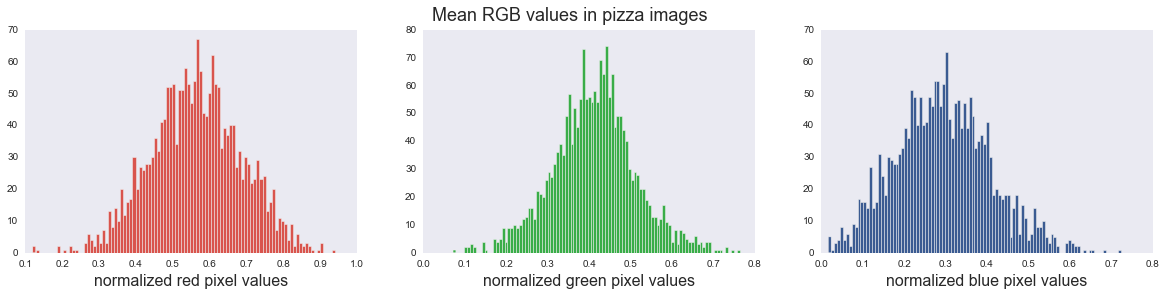

In [117]:
sns.set_style("dark")
fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.despine()

sns.distplot(df.red[df.label == 1], bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["pale red"]}, ax=ax[0])
ax[0].set_xlabel('normalized red pixel values', size = 16, )

sns.distplot(df.green[df.label == 1], bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["medium green"]}, ax=ax[1])
ax[1].set_xlabel('normalized green pixel values', size = 16)

sns.distplot(df.blue[df.label == 1], bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["denim blue"]}, ax=ax[2])
ax[2].set_xlabel('normalized blue pixel values', size = 16)

plt.suptitle('Mean RGB values in pizza images', size=18)
plt.show()

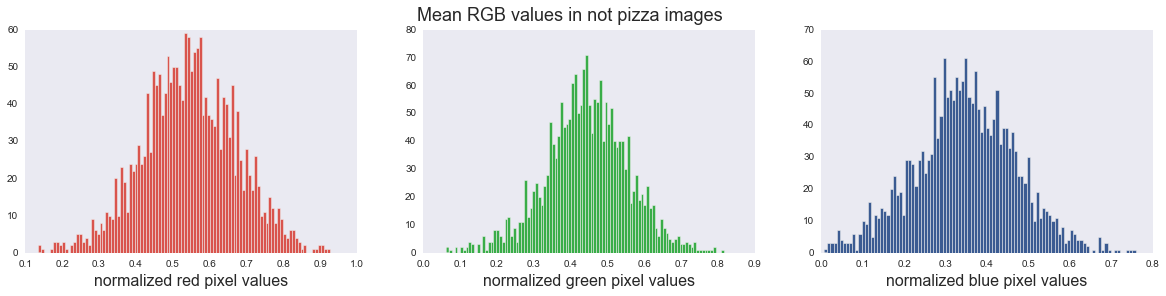

In [118]:
sns.set_style("dark")
fig, ax = plt.subplots(1,3,figsize=(18,4))
sns.despine()

sns.distplot(df.red[df.label == 0], bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["pale red"]}, ax=ax[0])
ax[0].set_xlabel('normalized red pixel values', size = 16)

sns.distplot(df.green[df.label == 0], bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["medium green"]}, ax=ax[1])
ax[1].set_xlabel('normalized green pixel values', size = 16)

sns.distplot(df.blue[df.label == 0], bins=100, kde=False, hist_kws={"alpha": 1, "color": sns.xkcd_rgb["denim blue"]}, ax=ax[2])
ax[2].set_xlabel('normalized blue pixel values', size = 16)

plt.suptitle('Mean RGB values in not pizza images', size=18)
plt.show()

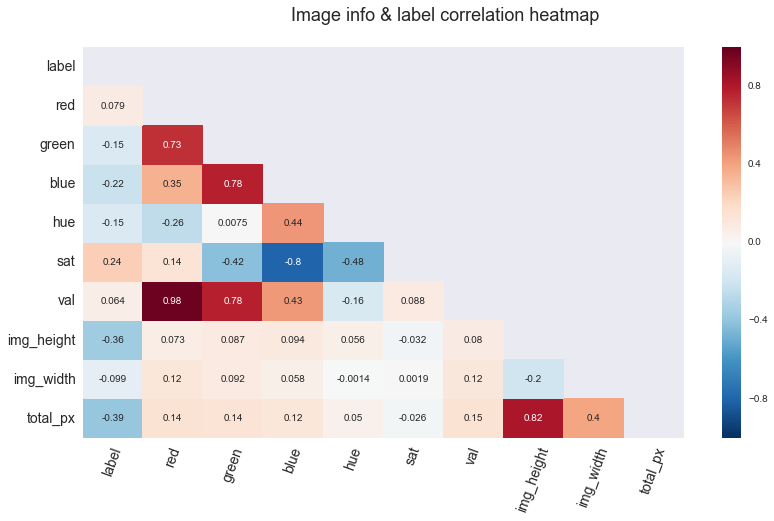

In [120]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(12,7))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df.corr(), mask=mask, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=70)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
plt.suptitle('Image info & label correlation heatmap', size=18)
plt.show()

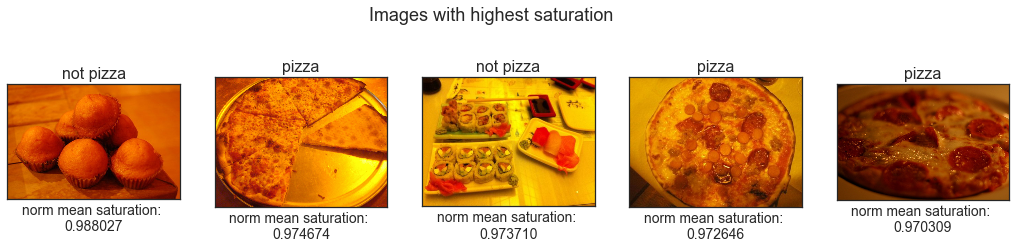

In [180]:
# display images with highest saturation
sns.set_style("white")
fig, ax = plt.subplots(1,5,figsize=(16,4))

sat_df = df.sort_values('sat', ascending=False)
images_plot = []

for img in sat_df['full_path'][:5]:
    image = cv2.imread(img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_plot.append(image_rgb)
    
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(images_plot[i])
    label = 'not pizza' if sat_df.label.values[i] == 0 else 'pizza'
    plt.title(label, size=16)
    plt.xlabel("norm mean saturation: \n%f" % sat_df.sat.values[i], size=14)

plt.suptitle('Images with highest saturation', size=18)
plt.show() 

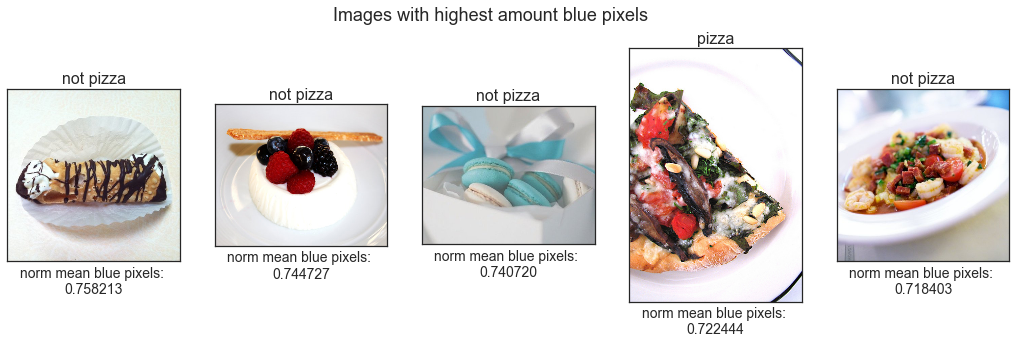

In [181]:
# display images with highest amount blue pixels
sns.set_style("white")
fig, ax = plt.subplots(1,5,figsize=(16,5))

blue_df = df.sort_values('blue', ascending=False)
images_plot = []

for img in blue_df['full_path'][:5]:
    image = cv2.imread(img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_plot.append(image_rgb)
    
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(images_plot[i])
    label = 'not pizza' if blue_df.label.values[i] == 0 else 'pizza'
    plt.title(label, size=16)
    plt.xlabel("norm mean blue pixels: \n%f" % blue_df.blue.values[i], size=14)

plt.suptitle('Images with highest amount blue pixels', size=18)
plt.show() 

---
## <a name="4">Image preprocessing</a>
There was no data cleaning other than [organizing the images](data_setup.ipynb) into correct directory structure required for the keras method `.flow_from_directory` but there was some image preprocessing using the ImageDataGenerator class. The goal with the preprocessing is to make the most of few training examples and "augment" via random transformations so model never sees the same image twice which helps prevent overfitting and model to generalize better.

You can standardize pixel values across all the image data by using feature standardization which is similar to standardization performed on each column in a dataframe.

You can perform feature standardization by setting the featurewise_center and featurewise_std_normalization arguments on the ImageDataGenerator class. These are in fact set to True by default and creating an instance of ImageDataGenerator with no arguments will have the same effect.

When using deep convolutional neural networks (CNNs) for image classification tasks, it’s common to apply several transformations to the images in order to augment the data and reduce overfitting. For example, images are often randomly cropped, mirrored, rotated, and blurred to artificially increase the number of training examples. It’s much more efficient to do this in real-time rather than store extra transformed images on disk.

Large image datasets that won’t fit in memory all at once are loaded into GPU memory one batch at a time during training. Data augmentation steps are usually applied on the CPU. In Python, generators are often used to do this iteration over batches. For example,

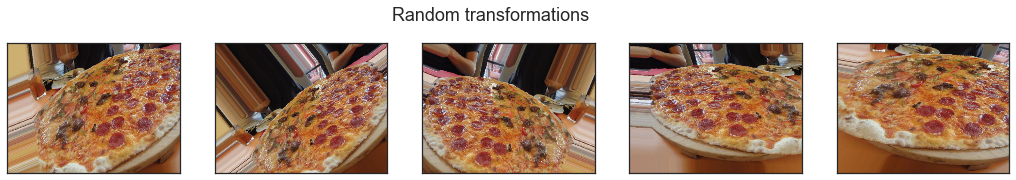

In [188]:
sns.set_style("white")
fig, ax = plt.subplots(1,5,figsize=(16,3))

pizza_transformed = [f for f in glob.glob('./transformations/*') if f.endswith('.jpg')]
images_plot = []

for img in pizza_transformed[:5]:
    image = cv2.imread(img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_plot.append(image_rgb)
    
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(images_plot[i])

plt.suptitle('Random transformations', size=18)
plt.show() 